In [ ]:
import os
import re
import datetime
import warnings

import numpy as np
import pandas as pd
from PIL import Image

from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
from skimage.transform import resize

from tensorflow.keras.models import Model

from keras.preprocessing.text import Tokenizer

from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Layer, Dropout

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_df = pd.read_csv('/content/drive/MyDrive/diploma_project/data.csv')

In [ ]:
# Taken file from  kaggle to identify whether image is front or lateral: https://www.kaggle.com/usersan/chest-x-ray-indiana-u-frontal-or-lateral
view_df = pd.read_csv("/content/drive/MyDrive/diploma_project/indiana_projections.csv")
view_df.head()


,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [ ]:
def find_img_view(images):
    front_lst = []
    laterals = ""
    for img in images:
        views = view_df[view_df['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", img).group())][
            'projection'].values
        if views == "Lateral":
            laterals = img
        else:
            front_lst.append(img)
    return front_lst, laterals

In [ ]:
columns = ["front_image", "lateral_image", "impression"]

final_df = pd.DataFrame(columns=columns)
oneimages_df = pd.DataFrame(columns=columns)

for row in data_df.iterrows():
    imglist = row[1]['image_id'].split(',')

    if len(imglist) > 2:
        frontimg, lateralimg = find_img_view(imglist)

        if lateralimg == "":
            frontimg, lateralimg = frontimg[:-1], frontimg[-1]

        for i in frontimg:
            img_front = i
            img_lateral = lateralimg
            final_df = final_df.append(pd.Series([img_front, img_lateral, row[1]['impression']], index=columns), ignore_index=True)

    elif len(imglist) == 2:
        img_front = imglist[0]
        img_lateral = imglist[1]
        final_df = final_df.append(pd.Series([img_front, img_lateral, row[1]['impression']], index=columns), ignore_index=True)

    elif len(imglist) == 1:
        img_front = imglist[0]
        img_lateral = imglist[0]
        oneimages_df = oneimages_df.append(pd.Series([img_front, img_lateral, row[1]['impression']], index=columns),
                                           ignore_index=True)

In [ ]:
train_first, test_first = train_test_split(final_df, test_size=0.10, random_state=42, shuffle=True)
train_first, validation_first = train_test_split(train_first, test_size=0.10, random_state=42, shuffle=True)

print(train_first.shape)
print(test_first.shape)
print(validation_first.shape)

(2860, 3)
(354, 3)
(318, 3)


In [ ]:
train_second, test_second = train_test_split(oneimages_df, test_size=0.10, random_state=42, shuffle=True)
train_second, valid_second = train_test_split(train_second, test_size=0.10, random_state=42, shuffle=True)

print(train_second.shape)
print(test_second.shape)
print(valid_second.shape)

(360, 3)
(45, 3)
(41, 3)


In [ ]:
train_data = np.append(train_first, train_second, axis=0)
test_data = np.append(test_first, test_second, axis=0)
valid = np.append(validation_first, valid_second, axis=0)
train_data.shape, test_data.shape, valid.shape

((3220, 3), (399, 3), (359, 3))

In [ ]:
from sklearn.utils import shuffle
train_data = shuffle(train_data, random_state=15)
test_data = shuffle(test_data, random_state=15)
valid = shuffle(valid, random_state=15)

In [ ]:
train_data = train_data[:-20, :]
train_data.shape

validation_data = valid[:-9, :]
validation_data.shape


(350, 3)

In [ ]:
columns = ["front_image", "lateral_image", "impression"]

train_data = pd.DataFrame(train_data, columns=columns)
test_data = pd.DataFrame(test_data, columns=columns)
validation_data = pd.DataFrame(validation_data, columns=columns)

In [ ]:
def decoder_io(df):

    df['decoder_input'] = '<start>' + ' ' + df.impression.astype(str)  # Decoder input
    df['decoder_output'] = df.impression.astype(str) + ' ' + '<end>'  # Decoder output
    df['impression'] = '<start> ' + df.impression + ' <end>'
    return df

In [ ]:
train_data = decoder_io(train_data)
validation_data = decoder_io(validation_data)
test_data = decoder_io(test_data)

In [ ]:
image_model = DenseNet121(weights='/content/drive/MyDrive/diploma_project/brucechou1983_CheXNet_Keras_0.3.0_weights.h5',
                          classes=14, input_shape=(256, 256, 3))

model = Model(image_model.input, image_model.layers[-2].output)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.692339 to fit



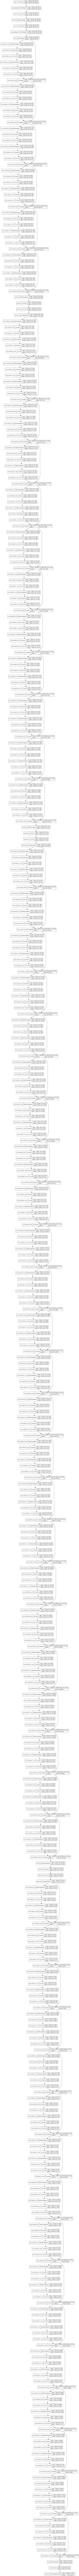

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_1_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def change_image(image_name):

    image = Image.open(image_name)
    changedimage = np.asarray(image.convert("RGB"))
    changedimage = np.asarray(changedimage)
    changedimage = preprocess_input(changedimage)
    changedimage = resize(changedimage, (256, 256, 3))
    changedimage = np.expand_dims(changedimage, axis=0)
    changedimage = np.asarray(changedimage)

    return changedimage

In [ ]:
def load_image_features(df):
    path = '/content/images/'
    front_img = df['front_image'].astype(str).tolist()
    lateral_img = df['lateral_image'].astype(str).tolist()

    image_features = []
    for each in tqdm(range(len(front_img))):
        fimg = change_image(path + front_img[each])
        limg = change_image(path + lateral_img[each])
        f_features = model.predict(fimg)
        l_features = model.predict(limg)
        f_features = np.vstack(f_features).astype(np.float)
        l_features = np.vstack(l_features).astype(np.float)

        tensor = np.concatenate((f_features, l_features), axis=1)

        image_features.append(tensor)
    df['image_features'] = image_features
    return df

In [ ]:
cwd = os.getcwd()

import tarfile

images = tarfile.open('/content/drive/MyDrive/diploma_project/NLMCXR_png.tgz')
images.extractall(cwd + '/images/')


In [ ]:
train_data = load_image_features(train_data)
test_data = load_image_features(test_data)
validation_data = load_image_features(validation_data)

train_np = train_data.to_numpy()
test_np = test_data.to_numpy()
validation_np = validation_data.to_numpy()

# with open('train.npy', 'wb') as f:
#     np.save(f, train_np)
# with open('test.npy', 'wb') as f:
#     np.save(f, test_np)
# with open('validation.npy', 'wb') as f:
#     np.save(f, validation_np)

100%|██████████| 350/350 [01:47<00:00,  3.25it/s]


In [ ]:
train_data.head()

,front_image,lateral_image,impression,decoder_input,decoder_output,image_features
0,CXR3607_IM-1781-1001.png,CXR3607_IM-1781-1001.png,<start> opacities in the left base the appeara...,<start> opacities in the left base the appeara...,opacities in the left base the appearance whic...,"[[0.0002352507144678384, 0.001554036745801568,..."
1,CXR2725_IM-1186-1001.png,CXR2725_IM-1186-2001.png,<start> no acute findings <end>,<start> no acute findings,no acute findings <end>,"[[0.00025528023252263665, 0.001511823851615190..."
2,CXR556_IM-2156-1001-0001.png,CXR556_IM-2156-1001-0002.png,<start> no acute cardiopulmonary disease <end>,<start> no acute cardiopulmonary disease,no acute cardiopulmonary disease <end>,"[[1.4174689567880705e-05, 0.001751085743308067..."
3,CXR2514_IM-1036-1001.png,CXR2514_IM-1036-2001.png,<start> no acute cardiopulmonary process <end>,<start> no acute cardiopulmonary process,no acute cardiopulmonary process <end>,"[[0.00020564816077239811, 0.001744810491800308..."
4,CXR3673_IM-1828-1001.png,CXR3673_IM-1828-1002.png,<start> left midlung opacity may be secondary ...,<start> left midlung opacity may be secondary ...,left midlung opacity may be secondary to acute...,"[[4.796340726898052e-05, 0.0016978217754513025..."


In [ ]:
token = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n')
token.fit_on_texts(train_data['impression'])

token.word_index['<pad>'] = 0
token.index_word[0] = '<pad>'
vocab_size = len(token.word_index) + 1
print('Vocab size - ', vocab_size)

Vocab size -  1401


In [ ]:
decoder_ip_train = token.texts_to_sequences(train_data.decoder_input)
decoder_op_train = token.texts_to_sequences(train_data.decoder_output)
decoder_ip_validation = token.texts_to_sequences(validation_data.decoder_input)
decoder_op_validation = token.texts_to_sequences(validation_data.decoder_output)

In [ ]:
max_len = 100
decoder_input = pad_sequences(decoder_ip_train, maxlen=max_len, padding='post')
decoder_output = pad_sequences(decoder_op_train, maxlen=max_len, padding='post')
Validation_decoder_input = pad_sequences(decoder_ip_validation, maxlen=max_len, padding='post')
Validation_decoder_output = pad_sequences(decoder_op_validation, maxlen=max_len, padding='post')
print(decoder_input[:1])

[[ 1 58 30  8 15 72  8 92 99 67 17 31 79 20  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]


In [ ]:
words_vals = {}
word_keys = {}
for key, value in (token.word_index).items():
    words_vals[key] = value
    word_keys[value] = key

In [ ]:
class Encoder(tf.keras.Model):

    def __init__(self, lstm_cells):
        super().__init__()
        self.lstm_units = lstm_cells
        self.dense = Dense(self.lstm_units, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=40),
                           name='encoder_dense_layer')
        self.dropout = Dropout(0.3)

    def call(self, img_feature):
        self.encoder_op = self.dense(img_feature)
        self.encoder_op = self.dropout(self.encoder_op)

        return self.encoder_op
class Decoder(Model):

    def __init__(self, vocab_size, embedding, lstm_cells):
        super().__init__()
        self.vocab_size = vocab_size
        self.lstm_units = lstm_cells
        self.embedding = embedding

        self.dropout = Dropout(0.3)
        self.embedding = Embedding(self.vocab_size, self.embedding, trainable=True)
        self.lstm = LSTM(self.lstm_units, return_sequences=True, name="Decoder_LSTM")

    def call(self, text_feature):
        self.target_embd = self.embedding(text_feature)
        self.target_embd = self.dropout(self.target_embd)
        self.lstm_output = self.lstm(self.target_embd)

        return self.lstm_output

In [ ]:
class Encoder_decoder(Model):

    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super().__init__()

        self.vocab_size = vocab_size
        self.lstm_units = lstm_units
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(self.lstm_units)
        self.decoder = Decoder(vocab_size, embedding_dim, lstm_units)

        self.dense = TimeDistributed(Dense(self.vocab_size, activation='softmax'))
        self.dropout = Dropout(0.3)

    def call(self, data):

        self.encoder_op = self.encoder(data[0])
        self.decoder_op = self.decoder(data[1])

        self.add = tf.keras.layers.Add()([self.encoder_op, self.decoder_op])
        self.concat = self.dropout(self.add)
        output = self.dense(self.concat)

        return output

In [ ]:
lstm_units = 512
embedding_dim = 300
tf.keras.backend.clear_session()
# This will clear all tensorflow session
base_model = Encoder_decoder(vocab_size, embedding_dim, lstm_units)
base_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy')

In [ ]:
train_features = np.vstack(train_data.image_features).astype(np.float)
validation_features = np.vstack(validation_data.image_features).astype(np.float)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, baseline=None, verbose=1,
                                              restore_best_weights=True)
reduce_learningrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode='min', verbose=1, patience=5,
                                                           min_lr=0.000001)

base_model.fit([train_features, decoder_input], decoder_output,
               validation_data=([validation_features, Validation_decoder_input], Validation_decoder_output),
               batch_size=25, epochs=100, callbacks=[early_stop, reduce_learningrate])

base_model.save_weights('Basic_model.h5')
# !cp Basic_model.h5 "drive/My Drive/diploma_project"

Epoch 1/100
128/128 [==============================] - 13s 76ms/step - loss: 1.4328 - val_loss: 0.9668 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 9s 69ms/step - loss: 0.5841 - val_loss: 0.4358 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 9s 69ms/step - loss: 0.4570 - val_loss: 0.3913 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 9s 72ms/step - loss: 0.4112 - val_loss: 0.3569 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 9s 72ms/step - loss: 0.3735 - val_loss: 0.3317 - lr: 0.0010
Epoch 6/100
128/128 [==============================] - 9s 69ms/step - loss: 0.3446 - val_loss: 0.3138 - lr: 0.0010
Epoch 7/100
128/128 [==============================] - 9s 69ms/step - loss: 0.3211 - val_loss: 0.3017 - lr: 0.0010
Epoch 8/100
128/128 [==============================] - 9s 69ms/step - loss: 0.3017 - val_loss: 0.2952 - lr: 0.0010
Epoch 9/100
128/128 [==============================] - 9s 71ms/step - loss: 0.2

In [ ]:
import keras

base_model.save("Basic_model")
# !cp -r Basic_model "drive/My Drive/diploma_project"
base_model = keras.models.load_model("/content/Basic_model")



INFO:tensorflow:Assets written to: Basic_model/assets


INFO:tensorflow:Assets written to: Basic_model/assets


In [ ]:
def preprocess_image(image1, image2):

    path = '/content/images/'

    image_features = []
    for img in range(len(image1)):
        img1 = change_image(path + image1)
        img2 = change_image(path + image2)
        img1_features = model.predict(img1)
        img2_features = model.predict(img2)
        img1_features = np.vstack(img1_features).astype(np.float)
        img2_features = np.vstack(img2_features).astype(np.float)

        tensor = np.concatenate((img1_features, img2_features), axis=1)

    return tensor

In [ ]:
def evaluate(image1, image2):


    img_tensor = preprocess_image(image1, image2)
    image_features = np.vstack(img_tensor).astype(np.float)

    encoder_output = base_model.layers[0](image_features)
    encoder_output = base_model.layers[0].dropout(encoder_output)

    # Here replace with index of <start> in the english vocab
    input_sequence = np.ones((1, 1)) * words_vals['<start>']
    predicted_senence = "<start>"

    for i in range(25):
        decoder_output = base_model.layers[1].embedding(input_sequence)
        decoder_output = base_model.layers[1].dropout(decoder_output)
        decoder_output = base_model.layers[1].lstm(decoder_output)

        output = tf.keras.layers.Add()([encoder_output, decoder_output])
        output = base_model.layers[2](output)

        input_sequence = np.reshape(np.argmax(output), (1, 1))
        predicted_senence = predicted_senence + ' ' + word_keys[input_sequence[0][0] + 1]

        if (input_sequence[0][0] == words_vals['<end>']):
            break

    return predicted_senence.strip()

In [ ]:
def test_impression(img_data):

    path = '/content/images/'
    result = evaluate(img_data[0], img_data[1])

    fig, axies = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axies.flatten()):
        img_ = mpimg.imread(path + img)
        imgplot = axies[count].imshow(img_, cmap='bone')
        count += 1
    plt.show()

    print('Acutal :', img_data[2])
    print("Predicted:", result)
    print('BLEU Score :-', sentence_bleu(img_data[2], result))

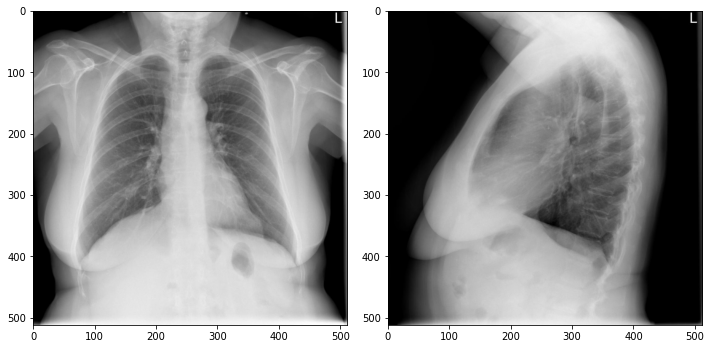

Acutal : <start> no acute cardiopulmonary disease <end>
Predicted: <start> acute cardiopulmonary disease of acute cardiopulmonary disease of acute cardiopulmonary disease of acute cardiopulmonary disease of acute cardiopulmonary disease of acute cardiopulmonary disease of acute
BLEU Score :- 0.5404400337750168


In [ ]:
test_impression(test_data.values[105])

In [ ]:
test_data